In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime
import os
import numpy as np
import re
import statistics

In [7]:
"""
    Loads all of the weather dfs.
"""
WEATHER_DIR = "./weather/"
CITY_SUFFIXES = ["_melbourne", "_sydney", "_adelaide", "_brisbane"]
CITY_DIRS = [WEATHER_DIR + "weather" + suffix + ".csv" for suffix in CITY_SUFFIXES]

mel, syd, adl, brs = [pd.read_csv(city_dir) for city_dir in CITY_DIRS]

In [8]:
"""
    Loads price df.
"""
price_demand=pd.read_csv(WEATHER_DIR + 'price_demand_data.csv')


In [65]:
#Checks whether weather df columns are the same.

col_strings = ["-".join(list(df.columns)) for df in [mel, syd, adl, brs]]
assert col_strings[0] == col_strings[1]
assert col_strings[1] == col_strings[2]
assert col_strings[2] == col_strings[3]

In [66]:
list(mel.columns)

['Date',
 'Minimum temperature (°C)',
 'Maximum temperature (°C)',
 'Rainfall (mm)',
 'Evaporation (mm)',
 'Sunshine (hours)',
 'Direction of maximum wind gust ',
 'Speed of maximum wind gust (km/h)',
 'Time of maximum wind gust',
 '9am Temperature (°C)',
 '9am relative humidity (%)',
 '9am cloud amount (oktas)',
 '9am wind direction',
 '9am wind speed (km/h)',
 '9am MSL pressure (hPa)',
 '3pm Temperature (°C)',
 '3pm relative humidity (%)',
 '3pm cloud amount (oktas)',
 '3pm wind direction',
 '3pm wind speed (km/h)',
 '3pm MSL pressure (hPa)']

In [67]:
"""
    Temp (Celsius)
    Relative humidity x2 (Percentage),
    wind speed (km/h) note: values are strings. Some entries are "Calm". Others "30.00" floatish
    wind direction (Compass direction) 
    cloud amount (oktas)
    MSL pressure (hPa) hecto Pascal = 100 Pascal 
"""

#these dont have number values . N, NW, SSE etc...
direction_columns = ["Direction of maximum wind gust ", "9am wind direction", "3pm wind direction"]
speed_columns = ["Speed of maximum wind gust (km/h)", "9am wind speed (km/h)"]

qualitative_columns = ["Direction of maximum wind gust ", "9am wind direction", "3pm wind direction", "Speed of maximum wind gust (km/h)", "9am wind speed (km/h)"]
#these have float values
float_columns = ["Speed of maximum wind gust (km/h)", "Time of maximum wind gust"]
#too may columns have different types...

In [68]:
mel["Time of maximum wind gust"].sort_values() #dtype object
mel["Speed of maximum wind gust (km/h)"].sort_values() #dtype float
mel["Direction of maximum wind gust "].unique() #dtype object

array(['S', 'SSW', 'SE', 'NNW', 'NW', 'SW', 'N', 'SSE', 'WSW', 'ESE', 'E',
       'NNE', 'WNW', 'W', 'NE', nan, 'ENE'], dtype=object)

In [69]:
direction_lookup = {
    "S": 270.0,
    "SSW": 247.5,
    "SE": 315.0,
    "NNW": 112.5,
    "NW": 135.0,
    "SW": 225.0,
    "N": 90.0,
    "SSE": 292.5,
    "WSW": 202.5,
    "ESE": 337.5,
    "E": 0.0,
    "NNE": 67.5,
    "WNW": 157.5,
    "W": 180.0,
    "NE": 45.0,
    "ENE": 22.5
}



def process_speed_series(speed_series):
    return pd.to_numeric(speed_series.loc[speed_series != "Calm"].dropna())




def process_direction_series(direction_series):
    """
        Converts compass direction series with values in the form "N", "ENE" to 
        degrees from the horizontal in the range [0, 360)
    """
    return direction_series.dropna().apply(lambda direction: direction_lookup[direction])



In [88]:
def hour_minute_to_seconds(time):
    """
        Returns seconds after midnight for an individual 
        time string of the form "hh:mm".
    """
    times = time.split(":")
    hour = int(times[0])
    minute = int(times[1])
    seconds_after_midnight = 60 * (hour * 60  + minute)
    return seconds_after_midnight




def process_time(time_series):
    """
        Converts a series with values of the form 'hh:mm' to 
        seconds after midnight aka '00:00' for each time value.
    """
    return time_series.dropna().apply(lambda timestr: hour_minute_to_seconds(timestr))





In [72]:
def get_time_differences(time_string_series):
    """
        Takes a series containing strings in the form "2022-03-22"
        and returns an array of integers representing number of days since
        the earliest date in the series.
        i.e. if the earliest date in the series is 2022-03-22, the position
        in the time-difference array corresponding to 2022-03-26 will be 4 
        since 03-26 is 4 days after the earliest date, 03-22.
    """
    datetimes = time_string_series.apply(lambda time_string: get_datetime(time_string))
    time_differences = [(datetime-datetimes[0]).days for datetime in datetimes]
    return time_differences

In [100]:
def get_datetime(time_string):
    """
        Takes in a string in the form "2022-03-22"
        and returns a corresponding datetime date object
    """
    return date(*[int(time) for time in time_string.split("-")])

upper:  2
lower:  0
['Minimum temperature (°C)', 'Maximum temperature (°C)']
upper:  4
lower:  2
['Rainfall (mm)', 'Evaporation (mm)']
upper:  6
lower:  4
['Sunshine (hours)', 'Direction of maximum wind gust ']
upper:  8
lower:  6
['Speed of maximum wind gust (km/h)', 'Time of maximum wind gust']
upper:  10
lower:  8
['9am Temperature (°C)', '9am relative humidity (%)']
upper:  12
lower:  10
['9am cloud amount (oktas)', '9am wind direction']
upper:  14
lower:  12
['9am wind speed (km/h)', '9am MSL pressure (hPa)']
upper:  16
lower:  14
['3pm Temperature (°C)', '3pm relative humidity (%)']
upper:  18
lower:  16
['3pm cloud amount (oktas)', '3pm wind direction']
upper:  20
lower:  18
['3pm wind speed (km/h)', '3pm MSL pressure (hPa)']


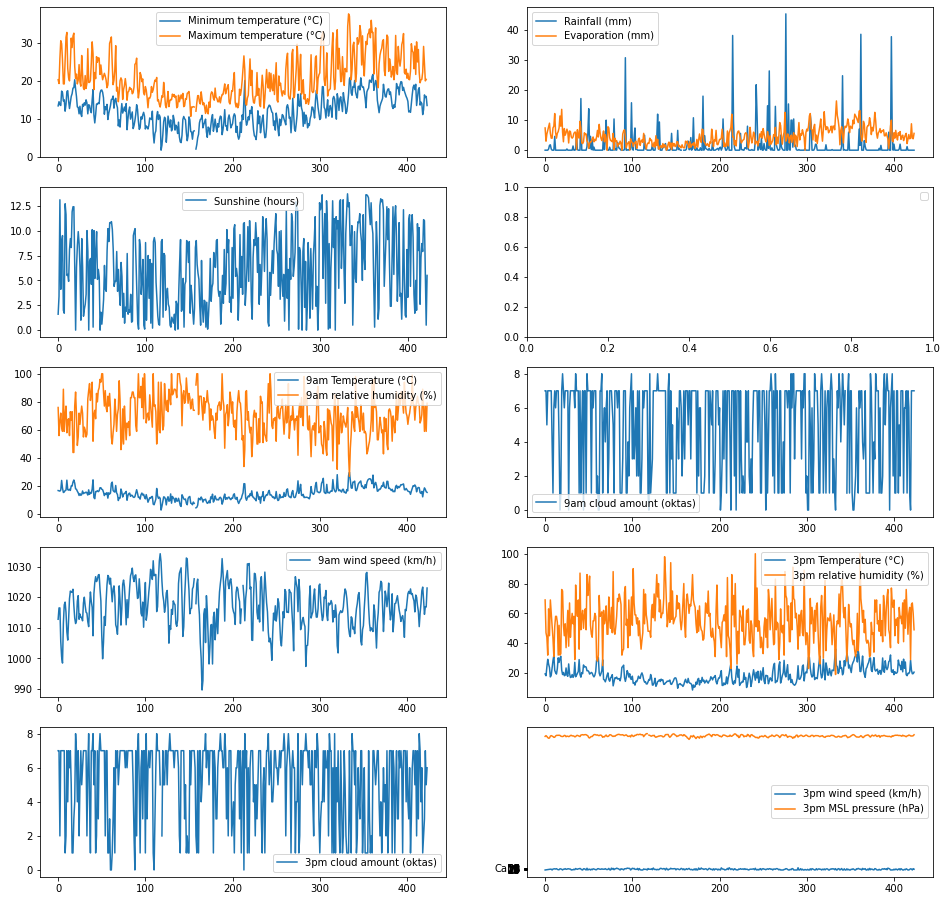

In [74]:
num_rows = 5
num_cols = 2
weather_df = mel
max_plot_per_fig = int(20 / (num_rows * num_cols))

fig, ax = plt.subplots(num_rows, num_cols, figsize=(16,16))

time_differences = get_time_differences(weather_df["Date"])

#excludes date field
fields = list(weather_df.columns)[1:]
for i in range(0,num_rows):
    for j in range(0,num_cols):
        field_i_lower = (num_cols * i + j) * max_plot_per_fig
        field_i_upper = field_i_lower + max_plot_per_fig
        print("upper: ", field_i_upper)
        print("lower: ", field_i_lower)
        print(fields[field_i_lower : field_i_upper])
        [ax[i, j].plot(time_differences, weather_df[field]) for field in fields[field_i_lower : field_i_upper] if (field not in qualitative_columns and field not in float_columns)]
        ax[i, j].legend(fields[field_i_lower : field_i_upper])

#[(ax[0].plot(time_differences, weather_df[field])) for field in fields[:max_plot_per_fig]]
#ax[0].legend(fields[:4])

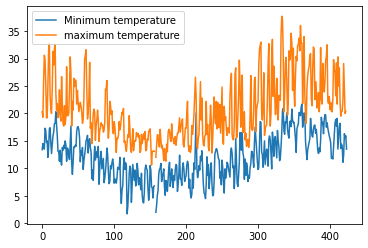

In [75]:
fig2, ax2 = plt.subplots()
ax2.plot(get_time_differences(mel["Date"]), mel["Minimum temperature (°C)"])
ax2.plot(get_time_differences(mel["Date"]), mel["Maximum temperature (°C)"])
ax2.legend(["Minimum temperature","maximum temperature"])

In [76]:
def get_outlier1(df, col):
    """ Takes a dataframe and a colum name
        Returns the index of the ones that are indentified as outliers
        Note: outliers identified based on the change in values
        therefore only work for values that are considered more or less continuous
        (data that are dependent on what happen the day before)
        e.g. temperature anti-example rainfall"""

    distance_lst=[df[col][i] - df[col][i-1] for i in range(1, len(df[col]))]
    Q1=np.nanpercentile(distance_lst, 25)
    Q3=np.nanpercentile(distance_lst, 75)
    interquartile_range=1.5*(Q3-Q1)
    upper_bound=Q3+interquartile_range
    lower_bound=Q1-interquartile_range
    outliers_index=[]
    for i in range(0,len(distance_lst)):
        if distance_lst[i]>upper_bound or distance_lst[i]<lower_bound:
            outliers_index.append(i+1)  
    return outliers_index

In [97]:
price_demand.tail()
price_demand.sort_values(by=["REGION","SETTLEMENTDATE"], inplace=True)
price_demand.reset_index(inplace=True,drop=True)
price_demand.groupby(['REGION']).count()

,SETTLEMENTDATE,TOTALDEMAND,PRICESURGE
REGION,,,
NSW1,60000,60000,60000
QLD1,60000,60000,60000
SA1,60000,60000,60000
VIC1,60000,60000,60000


In [78]:
'''create a new dataframe where the total demand for each day is the average of all 
   and pricesurge is true if it's true for any time of the day'''

'''saved to a file named price_demand_sorte
   0-59999 NSW 60000-11999 QLD  12000-17999 SA    18000-23999 VIC'''

settlementdate_format=r'\d{4}/\d{2}/\d{2}'
settlementdate=list()
for dates in price_demand['SETTLEMENTDATE']:
    match=re.search(settlementdate_format, dates)
    if match.group(0) not in settlementdate:
        settlementdate.append(match.group(0))
price_demand_dated =pd.DataFrame(columns=price_demand.columns)
start_row=0
while start_row<239999:
    end_row=start_row
    BOOL=price_demand['PRICESURGE'][start_row]
    while re.search(settlementdate_format, price_demand['SETTLEMENTDATE'][end_row]).group(0)==re.search(settlementdate_format, price_demand['SETTLEMENTDATE'][start_row]).group(0) and price_demand['REGION'][start_row]==price_demand['REGION'][end_row]:
        if price_demand['PRICESURGE'][end_row]:
            BOOL=True
        end_row+=1
    price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
                               "SETTLEMENTDATE": re.search(settlementdate_format, price_demand['SETTLEMENTDATE'][start_row]).group(0),
                               "TOTALDEMAND": round(statistics.mean(price_demand['TOTALDEMAND'][start_row:end_row]),2),
                               "PRICESURGE": BOOL}, ignore_index=True)
    start_row=end_row+1


/tmp/ipykernel_34/2129979772.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/tmp/ipykernel_34/2129979772.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/tmp/ipykernel_34/2129979772.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/tmp/ipykernel_34/2129979772.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.appen

,SETTLEMENTDATE,TOTALDEMAND,PRICESURGE
REGION,,,
NSW1,60000,60000,60000
QLD1,60000,60000,60000
SA1,60000,60000,60000
VIC1,60000,60000,60000
